In [ ]:
# import packages
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np

In [ ]:
# GPU setting
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# VGG16_custom
class VGG16_custom(nn.Module):
    def __init__(self):
        super(VGG16_custom, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1), nn.BatchNorm2d(512), nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.BatchNorm2d(512), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.BatchNorm2d(512), nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.BatchNorm2d(512), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.AvgPool2d(kernel_size=1, stride=1)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [ ]:
# train
def train(model, trainloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(trainloader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

# evaluate
def evaluate(model, testloader, criterion, return_preds=False):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if return_preds:
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(testloader)
    epoch_acc = 100 * correct / total

    if return_preds:
        return epoch_loss, epoch_acc, all_labels, all_preds
    else:
        return epoch_loss, epoch_acc

In [ ]:
# CIFAR-10 preprocessing
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
# data loading
batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

# random label shuffle
trainset.targets = np.random.randint(0, 10, size=len(trainset)).tolist()

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = trainset.classes

100%|██████████| 170M/170M [00:01<00:00, 87.0MB/s]


In [ ]:
# lr, epochs
lr = 1e-3
epochs = 100

# VGG16_custom loading
model = VGG16_custom().to(device)

# loss, optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# training loop
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(1, epochs + 1):
    train_loss, train_acc = train(model, trainloader, criterion, optimizer)
    test_loss, test_acc = evaluate(model, testloader, criterion)

    print(f"[Epoch {epoch:2d}] | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:5.2f}%"
          f" || Test Loss: {test_loss:.4f} | Test Acc: {test_acc:5.2f}%")

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

[Epoch  1] | Train Loss: 2.3838 | Train Acc:  9.92% || Test Loss: 2.3094 | Test Acc:  9.72%
[Epoch  2] | Train Loss: 2.3109 | Train Acc: 10.05% || Test Loss: 2.3090 | Test Acc:  7.89%
[Epoch  3] | Train Loss: 2.3068 | Train Acc:  9.86% || Test Loss: 2.3057 | Test Acc:  9.83%
[Epoch  4] | Train Loss: 2.3066 | Train Acc:  9.90% || Test Loss: 2.3059 | Test Acc:  9.94%
[Epoch  5] | Train Loss: 2.3053 | Train Acc: 10.22% || Test Loss: 2.3068 | Test Acc:  9.96%
[Epoch  6] | Train Loss: 2.3052 | Train Acc: 10.00% || Test Loss: 2.3033 | Test Acc:  9.97%
[Epoch  7] | Train Loss: 2.3047 | Train Acc: 10.14% || Test Loss: 2.3042 | Test Acc: 10.22%
[Epoch  8] | Train Loss: 2.3050 | Train Acc:  9.92% || Test Loss: 2.3027 | Test Acc:  9.96%
[Epoch  9] | Train Loss: 2.3055 | Train Acc:  9.96% || Test Loss: 2.3121 | Test Acc: 11.55%
[Epoch 10] | Train Loss: 2.3041 | Train Acc: 10.10% || Test Loss: 2.3040 | Test Acc: 10.43%
[Epoch 11] | Train Loss: 2.3048 | Train Acc: 10.08% || Test Loss: 2.3062 | Test 

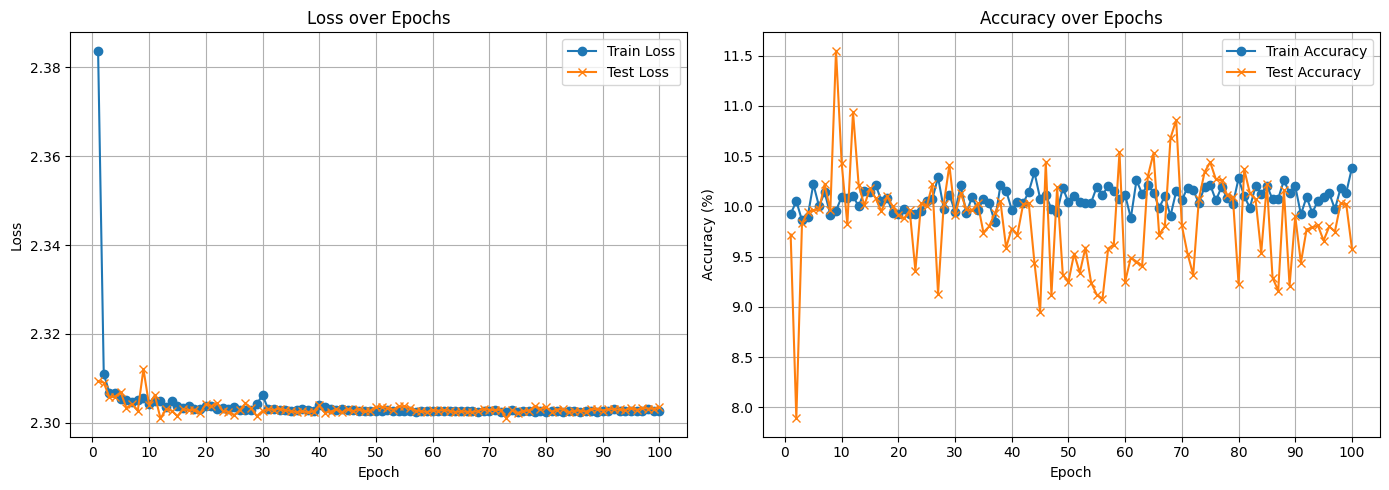

In [ ]:
import matplotlib.pyplot as plt

epochs_range = range(1, epochs + 1)

plt.figure(figsize=(14, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss', marker='o')
plt.plot(epochs_range, test_losses, label='Test Loss', marker='x')
plt.xticks(ticks=range(0, epochs + 1, 10))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs_range, test_accuracies, label='Test Accuracy', marker='x')
plt.xticks(ticks=range(0, epochs + 1, 10))
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("loss_accuracy_plot.png", dpi=300)  # 고해상도 저장
plt.show()


Final Test Accuracy: 9.58%


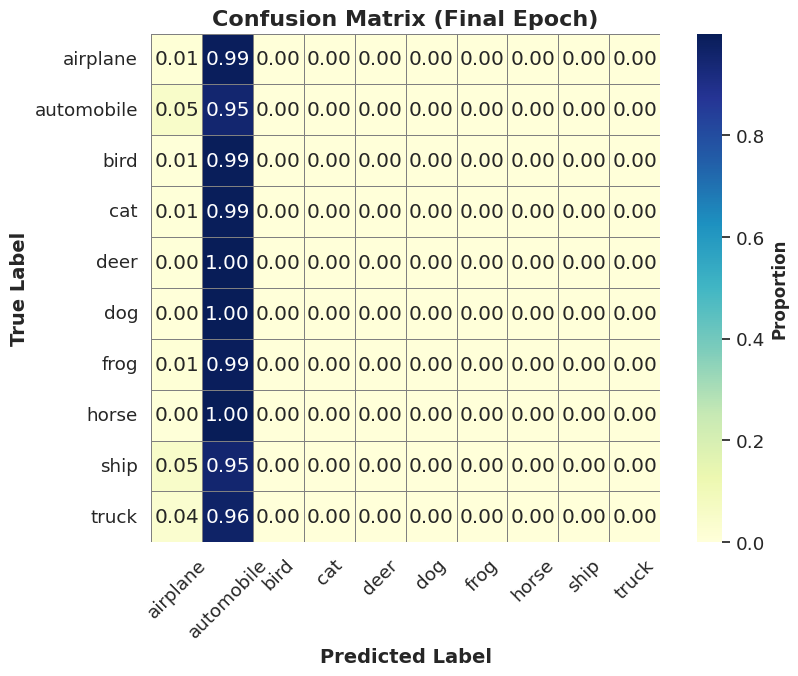


Class-wise Accuracy:
Class [airplane]: 0.90%
Class [automobile]: 94.90%
Class [bird]: 0.00%
Class [cat]: 0.00%
Class [deer]: 0.00%
Class [dog]: 0.00%
Class [frog]: 0.00%
Class [horse]: 0.00%
Class [ship]: 0.00%
Class [truck]: 0.00%


In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_confusion_matrix(y_true, y_pred, class_names, normalize=True):
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(9, 7))
    sns.set(font_scale=1.2)
    ax = sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d", cmap="YlGnBu",
                     xticklabels=class_names, yticklabels=class_names,
                     linewidths=0.5, linecolor='gray', cbar=True, square=True)

    colorbar = ax.collections[0].colorbar
    colorbar.set_label('Count' if not normalize else 'Proportion', fontsize=12, weight='bold')

    plt.xlabel('Predicted Label', fontsize=14, weight='bold')
    plt.ylabel('True Label', fontsize=14, weight='bold')
    plt.title('Confusion Matrix (Final Epoch)', fontsize=16, weight='bold')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig("confusion_matrix.png", dpi=300)
    plt.show()

def print_class_accuracy(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    class_correct = np.diag(cm)
    class_total = np.sum(cm, axis=1)
    class_accuracy = class_correct / class_total * 100

    print("\nClass-wise Accuracy:")
    for i, acc in enumerate(class_accuracy):
        print(f"Class [{class_names[i]}]: {acc:.2f}%")

final_loss, final_acc, all_labels, all_preds = evaluate(model, testloader, criterion, return_preds=True)

print(f"\nFinal Test Accuracy: {final_acc:.2f}%")

plot_confusion_matrix(all_labels, all_preds, class_names=classes)
print_class_accuracy(all_labels, all_preds, class_names=classes)